<a href="https://colab.research.google.com/github/SammyDMartin/fairness/blob/main/parameter_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contribution
**Add the possibility to pass in arbitrary metric to the ROC or CPP fit function**

**Perform (currently random) cross-validation search over weights in arbitarary fairness function and assess k-fold accuracy/fairness scores**

*search over fairness weight hyperparameters*

### **Step 1**
Install aif360 and setup environment

In [1]:
!git clone https://github.com/Trusted-AI/AIF360

fatal: destination path 'AIF360' already exists and is not an empty directory.


In [2]:
%cd AIF360 

/content/AIF360


In [3]:
%pip install '.[all]'

Processing /content/AIF360
  Created wheel for aif360: filename=aif360-0.4.0-cp37-none-any.whl size=557690 sha256=fe224a18c5a6b3eed766d7e871cbb156861ce8225e32399bdfc66c38b560e311
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jx8yj30/wheels/98/c1/ab/d8fba482498b80dd95f0c1940d349fb383ee734c04245e4a8e
Successfully built aif360
  Found existing installation: aif360 0.4.0
    Uninstalling aif360-0.4.0:
      Successfully uninstalled aif360-0.4.0


Download data


In [4]:
import urllib.request 

urls = [
  "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
	"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
	"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
]

filenames = [
  "/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/adult.data",
  "/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/adult.test",
  "/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/adult.names",
]

for i in range(len(urls)):
  url = urls[i]
  filename = filenames[i]
  print(url)
  print(filename)
  urllib.request.urlretrieve(url, filename)

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/adult.data
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/adult.test
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/adult.names


In [5]:
%cd examples

/content/AIF360/examples


Define Modified CalibratedEqOddsPostprocessing and Reject Option Classification

In [6]:
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics.binary_label_dataset_metric import BinaryLabelDatasetMetric
from aif360.metrics.classification_metric import ClassificationMetric
import numpy as np

class VariableCEP(CalibratedEqOddsPostprocessing):
    def set_NP(self, NP_rate):
        self.fn_rate = NP_rate[0]
        self.fp_rate = NP_rate[1]
    

def normed_rates(fp_rate, fn_rate):
    norm_const = float(fp_rate + fn_rate) if\
                      (fp_rate != 0 and fn_rate != 0) else 1
    return (fp_rate / norm_const), (fn_rate / norm_const)


from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

class InquisitiveRejectOptionClassification(RejectOptionClassification):

  def fit(self, dataset_true, dataset_pred, metric_fn=None):
      """Estimates the optimal classification threshold and margin for reject
      option classification that optimizes the metric provided.
      Note:
          The `fit` function is a no-op for this algorithm.
      Args:
          dataset_true (BinaryLabelDataset): Dataset containing the true
              `labels`.
          dataset_pred (BinaryLabelDataset): Dataset containing the predicted
              `scores`.
      Returns:
          RejectOptionClassification: Returns self.
      """
      fair_metric_arr = np.zeros(self.num_class_thresh*self.num_ROC_margin)
      balanced_acc_arr = np.zeros_like(fair_metric_arr)
      ROC_margin_arr = np.zeros_like(fair_metric_arr)
      class_thresh_arr = np.zeros_like(fair_metric_arr)

      cnt = 0
      # Iterate through class thresholds
      for class_thresh in np.linspace(self.low_class_thresh,
                                      self.high_class_thresh,
                                      self.num_class_thresh):

          self.classification_threshold = class_thresh
          if class_thresh <= 0.5:
              low_ROC_margin = 0.0
              high_ROC_margin = class_thresh
          else:
              low_ROC_margin = 0.0
              high_ROC_margin = (1.0-class_thresh)

          # Iterate through ROC margins
          for ROC_margin in np.linspace(
                              low_ROC_margin,
                              high_ROC_margin,
                              self.num_ROC_margin):
              self.ROC_margin = ROC_margin

              # Predict using the current threshold and margin
              dataset_transf_pred = self.predict(dataset_pred)

              dataset_transf_metric_pred = BinaryLabelDatasetMetric(
                                            dataset_transf_pred,
                                            unprivileged_groups=self.unprivileged_groups,
                                            privileged_groups=self.privileged_groups)
              classified_transf_metric = ClassificationMetric(
                                            dataset_true,
                                            dataset_transf_pred,
                                            unprivileged_groups=self.unprivileged_groups,
                                            privileged_groups=self.privileged_groups)

              ROC_margin_arr[cnt] = self.ROC_margin
              class_thresh_arr[cnt] = self.classification_threshold

              # Balanced accuracy and fairness metric computations
              balanced_acc_arr[cnt] = 0.5*(classified_transf_metric.true_positive_rate()\
                                      +classified_transf_metric.true_negative_rate())
              
              ### THE ONLY CHANGE I MAKE TO THE FUNCTION IS HERE
              if metric_fn:
                  fair_metric_arr[cnt] = metric_fn(classified_transf_metric)
              ###
              
              elif self.metric_name == "Statistical parity difference":
                  fair_metric_arr[cnt] = dataset_transf_metric_pred.mean_difference()
              elif self.metric_name == "Average odds difference":
                  fair_metric_arr[cnt] = classified_transf_metric.average_odds_difference()
              elif self.metric_name == "Equal opportunity difference":
                  fair_metric_arr[cnt] = classified_transf_metric.equal_opportunity_difference()
              
              

              cnt += 1

      rel_inds = np.logical_and(fair_metric_arr >= self.metric_lb,
                                fair_metric_arr <= self.metric_ub)
      if any(rel_inds):
          best_ind = np.where(balanced_acc_arr[rel_inds]
                              == np.max(balanced_acc_arr[rel_inds]))[0][0]
      else:
          print("Unable to satisfy fairness constraints")
          rel_inds = np.ones(len(fair_metric_arr), dtype=bool)
          best_ind = np.where(fair_metric_arr[rel_inds]
                              == np.min(fair_metric_arr[rel_inds]))[0][0]

      self.ROC_margin = ROC_margin_arr[rel_inds][best_ind]
      self.classification_threshold = class_thresh_arr[rel_inds][best_ind]

      return self

Import Everything needed

In [7]:
# Load all necessary packages
import sys
import numpy as np
import pandas as pd

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

from sklearn.model_selection import KFold as cross_val_split
from scipy import optimize

In [8]:
## import dataset - use compas
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

In [9]:
# code to identify the protected attributes from all of the dataset features
if dataset_used == "adult":
    dataset_orig = AdultDataset()
#     dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]  

In [10]:
#random seed for calibrated equal odds prediction
randseed = 12345679 

#train validation&test split
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.4], shuffle=True)

In [11]:
# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression() #logregression

#fit original model
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for training data
class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

In [12]:
#
# set up tradeoff cost-benefit calculation
include = False
N_reps = 1
N_values = 50


negs = []
accs = []
fps = []
fns = []

privileged_options = [True,False,None]


#whether to include all fp and all fn cost functions (True)
if include == True:
    n_range = np.linspace(0.00,1.00,N_values)
if include == False:
    n_range = np.linspace(0.01,0.99,N_values)

Set up both variable cep and inquisitiverejectoptionclassification

In [13]:
#set up equalized odds processing
cpp = VariableCEP(privileged_groups = privileged_groups,
                                        unprivileged_groups = unprivileged_groups,
                                        seed=randseed)
#ROC
ROC = InquisitiveRejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  # metric_name=metric_name,
                                  metric_ub=0.05, metric_lb=-0.05)

In [14]:
#for if you're using ROC - which f1, f2 to use for output results AND optimization
f1_name = 'false_negative_rate'
f2_name = 'false_positive_rate'

In [15]:
#disable to use Mojo's ROC optimiser
use_cpp = True

#for each fold - validation vs test split
split_interv = 0.3

#scale size of input range - are these normalized??
scale = 1

In [16]:
if use_cpp == True:
    post_processor = cpp
elif use_cpp == False:
    post_processor = ROC

Generate k folds (currently random)

In [17]:
def vt_split_process(dataset_orig_vt,split_indexes,shuf,class_thresh):
    dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split(num_or_size_splits=split_indexes,shuffle=shuf,seed=randseed)#validation_test split)
    dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
    dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

    dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
    dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

    X_valid = scale_orig.transform(dataset_orig_valid.features)
    y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

    X_test = scale_orig.transform(dataset_orig_test.features)
    y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

    dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
    dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

    y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
    y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
    y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
    dataset_orig_valid_pred.labels = y_valid_pred
        
    y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
    y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
    y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
    dataset_orig_test_pred.labels = y_test_pred

    return (dataset_orig_valid, dataset_orig_valid_pred, dataset_orig_test, dataset_orig_test_pred)

Function to perform cross validation sweep with given weights and function

In [18]:
def determine_cv_values(folds,post_processor,weight_tuple,name_tuple,pbar=None):
    for stream in folds:
        # Odds equalizing post-processing algorithm

        m1,m2,acc = np.zeros(3),np.zeros(3),np.zeros(3)

        ##########
        dataset_orig_valid, dataset_orig_valid_pred, dataset_orig_test, dataset_orig_test_pred = stream

        # Learn parameters to equalize odds and apply to create a new dataset
   
        if type(post_processor) == VariableCEP:
            f1_name = 'false_negative_rate'
            f2_name = 'false_positive_rate'
            post_processor.set_NP(weight_tuple)
            post_processor.fit(dataset_orig_valid, dataset_orig_valid_pred)
        elif type(post_processor) == InquisitiveRejectOptionClassification:
            f1_name = name_tuple[0]
            f2_name = name_tuple[1]

            post_processor.fit(dataset_orig_valid, dataset_orig_valid_pred, metric_fn = lambda metric: 
                            weight_tuple[0]*getattr(metric,f1_name)() + weight_tuple[1]*getattr(metric,f2_name)())

        dataset_transf_test_pred = post_processor.predict(dataset_orig_test_pred)

        """
        dataset_transf_valid_pred = post_processor.predict(dataset_orig_valid_pred)
        cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)
        """
        cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)
        #cm_transf_test.difference
        
        for idx,PR in enumerate(privileged_options):
            try:
                m1[idx] += getattr(cm_transf_test,f1_name)(privileged=PR)
            except Exception:
                #for if there is no difference for privileged/unpriveleged groups due to nature of the metric
                m1[idx] = 0
            try:
                m2[idx] += getattr(cm_transf_test,f2_name)(privileged=PR)
            except Exception:
                m2[idx] = 0
            result = cm_transf_test.accuracy(privileged=PR)
            acc[idx] += float(result)

        out = float(m2[1]/len(folds))
        if diag is True:
            print(weight_tuple, out)
        
        if pbar is not None:
            pbar.update(1)
        else:
            return out
    return m1/len(folds),m2/len(folds),acc/len(folds)

In [19]:
#kfold = cross_val_split(n_splits=reruns)

folds = []

for count in tqdm(range(N_reps)):
    si = [split_interv]
    folds.append(vt_split_process(dataset_orig_vt=dataset_orig_vt,split_indexes=si,shuf=True,class_thresh=class_thresh))

#valid, test = dataset_orig_vt.split(num_or_size_splits=si)

100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Without printing intermediates perform uniform CV search in 1D

In [20]:
diag = False

In [21]:
dataset_orig_valid_pred,dataset_orig_test_pred, dataset_new_valid_pred, dataset_new_test_pred = None,None,None,None
pbar = tqdm(total=(N_reps*N_values))
for neg in n_range:
    f1_weight = neg

    f2_weight = scale*(1.0 - f1_weight)
    f1_weight = scale*f1_weight

    w1_score,w2_score,accuracy = determine_cv_values(folds=folds,post_processor=post_processor,weight_tuple=(f1_weight,f2_weight),name_tuple=(f1_name,f2_name),pbar=pbar)

    fns.append(w1_score)
    fps.append(w2_score)
    accs.append(accuracy)
    negs.append(neg)

100%|██████████| 250/250 [01:22<00:00,  3.05it/s]

Gather max, min values and plot results

In [22]:
# plot results from fns, fps, accs, negs for different groups
collapse = lambda param, idx : [v[idx] for v in param]

getnames = {None:"full data", True:"privileged", False:"unprivileged"}

percentchange = lambda result: [100*((i-result[0])/result[0]) for i in result]

idx,PR = 2,None
maximised_accuracy = max(collapse(accs,idx))
maximised_idx = collapse(accs,idx).index(maximised_accuracy)
percentmax = lambda result: [100*((i-result[maximised_idx])/result[maximised_idx]) for i in result]

In [23]:
maximised_value_idx = lambda prop, idx : collapse(prop,idx).index(max(collapse(prop,idx)))
idx = 2
values = ['min {}'.format(f1_name),'min {}'.format(f2_name), 'max accuracy']
for idv,prop in enumerate([-1*np.array(fps),-1*np.array(fns),accs]):
    print("\n"+values[idv])
    maxi = maximised_value_idx(prop,idx)


    print("{}: {}".format(f1_name, round(collapse(fps,idx)[maxi],5)))
    print("{}: {}".format(f2_name, round(collapse(fns,idx)[maxi],5)))
    print("accs: {}".format(round(collapse(accs,idx)[maxi],5)))



min false_negative_rate
false_negative_rate: 0.01299
false_positive_rate: 0.09499
accs: 0.16651

min false_positive_rate
false_negative_rate: 0.01299
false_positive_rate: 0.09499
accs: 0.16651

max accuracy
false_negative_rate: 0.01299
false_positive_rate: 0.09499
accs: 0.16651


show accuracy, fp,fn % change from max accuracy for whole model

Text(0.5, 1.0, 'compas1d full data\nmax_acc=0.1665, fn_cost=0.01')

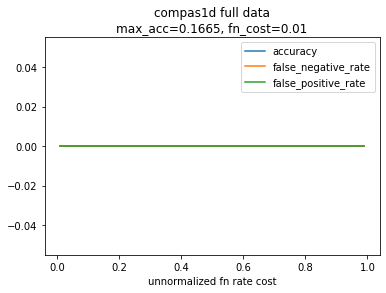

In [24]:
plt.figure()
plt.plot(negs,percentmax(collapse(accs,idx)),label='accuracy')
plt.plot(negs,percentmax(collapse(fns,idx)),label='{}'.format(f1_name))
plt.plot(negs,percentmax(collapse(fps,idx)),label='{}'.format(f2_name))
plt.xlabel('unnormalized fn rate cost')

plt.legend()
plt.title('compas1d {}\nmax_acc={}, fn_cost={}'.format(getnames[PR],round(maximised_accuracy,4),round(negs[maximised_idx],4)))

Text(0.5, 1.0, 'compas1d full data\nmax_acc=0.1665, fn_cost=0.01')

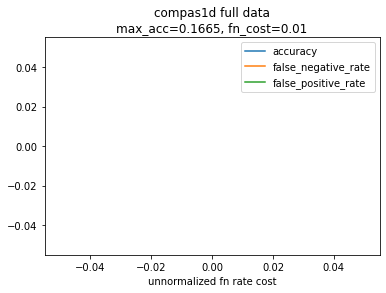

In [25]:
#show accuracy, fp,fn values % change around the max accuracy for whole model
width = 50
if maximised_idx < width:
    minv,maxv = 0,2*maximised_idx
else:
    minv,maxv = maximised_idx-width,maximised_idx+width

idx,PR = 2,None

diceup = lambda lst : lst[minv:maxv]

plt.figure()
plt.plot(diceup(negs),diceup(percentmax(collapse(accs,idx))),label='accuracy')
plt.plot(diceup(negs),diceup(percentmax(collapse(fns,idx))),label='{}'.format(f1_name))
plt.plot(diceup(negs),diceup(percentmax(collapse(fps,idx))),label='{}'.format(f2_name))
plt.xlabel('unnormalized fn rate cost')

plt.legend()
plt.title('compas1d {}\nmax_acc={}, fn_cost={}'.format(getnames[PR],round(maximised_accuracy,4),round(negs[maximised_idx],4)))

invalid value encountered in double_scalars


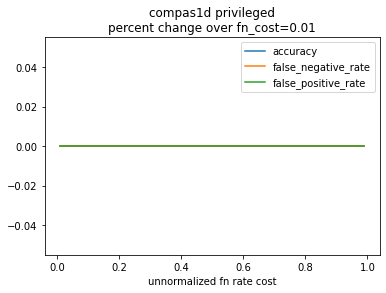

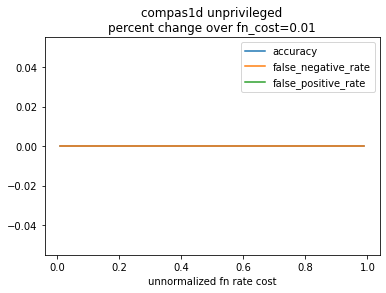

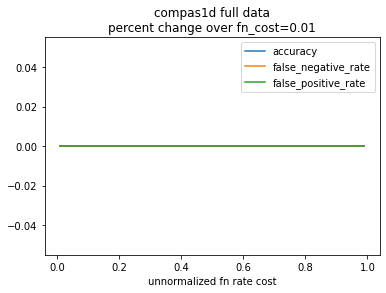

In [26]:
#show accuracy, fp,fn % change from the start
for idx,PR in enumerate(privileged_options):
    cost_0 = negs[0]
    plt.figure()
    plt.plot(negs,percentchange(collapse(accs,idx)),label='accuracy')
    plt.plot(negs,percentchange(collapse(fns,idx)),label='{}'.format(f1_name))
    plt.plot(negs,percentchange(collapse(fps,idx)),label='{}'.format(f2_name))
    plt.xlabel('unnormalized fn rate cost')

    plt.legend()
    plt.title('compas1d {}\npercent change over fn_cost={}'.format(getnames[PR],cost_0))

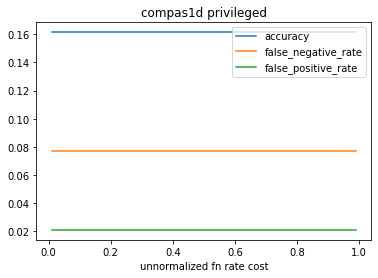

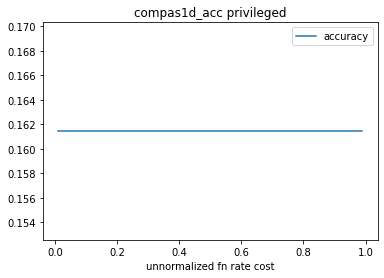

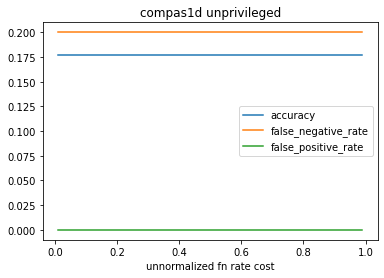

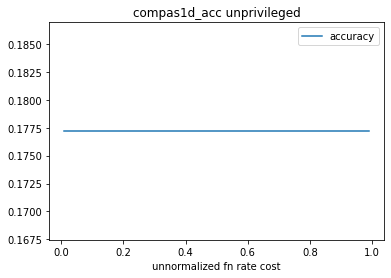

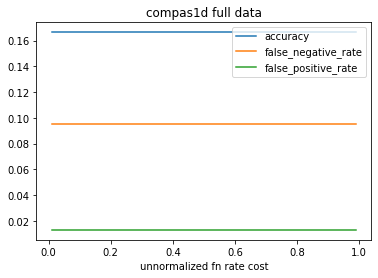

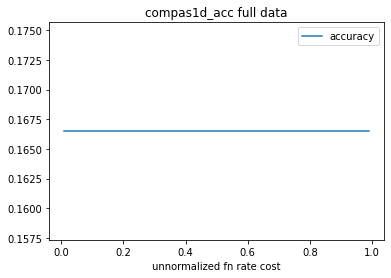

In [27]:
#show raw accuracy,fp,fn
for idx,PR in enumerate(privileged_options):
    plt.figure()
    plt.plot(negs,collapse(accs,idx),label='accuracy')
    plt.plot(negs,collapse(fns,idx),label='{}'.format(f1_name))
    plt.plot(negs,collapse(fps,idx),label='{}'.format(f2_name))
    plt.xlabel('unnormalized fn rate cost')

    plt.legend()
    plt.title('compas1d {}'.format(getnames[PR]))

    plt.figure()
    plt.plot(negs,collapse(accs,idx),label='accuracy')
    plt.xlabel('unnormalized fn rate cost')
    plt.legend()
    plt.title('compas1d_acc {}'.format(getnames[PR]))

Search using BasinHopping Optimizer (currently broken)

In [ ]:
#OPTIMIZE SEARCH
diag = True
process = lambda weight : [weight, 1-weight]
to_opt = lambda weights : -1*determine_cv_values(folds=folds,post_processor=post_processor,weight_tuple=process(weights[0]),name_tuple=(f1_name,f2_name))
res = optimize.basinhopping(func=to_opt,x0 = np.array([0.3]))
print(res)

[0.3, 0.7] 0.0
[0.3, 0.7] 0.0
[0.3000000149011612, 0.6999999850988388] 0.0
[0.2185710890918266, 0.7814289109081733] 0.0
[0.2185710890918266, 0.7814289109081733] 0.0
[0.2185711039929878, 0.7814288960070122] 0.0
[-0.21040354393968802, 1.210403543939688] 0.0
[-0.21040354393968802, 1.210403543939688] 0.0
[-0.21040352903852683, 1.2104035290385269] 0.0
[-0.6393781769712026, 1.6393781769712026] 0.0
[-0.6393781769712026, 1.6393781769712026] 0.0
[-0.6393781620700414, 1.6393781620700414] 0.0
[-1.0683528100027173, 2.0683528100027173] 0.0
[-1.0683528100027173, 2.0683528100027173] 0.0
[-1.0683527951015561, 2.068352795101556] 0.0
[-1.4973274430342318, 2.497327443034232] 0.0
[-1.4973274430342318, 2.497327443034232] 0.0
[-1.4973274281330706, 2.4973274281330706] 0.0
[-1.9263020760657463, 2.9263020760657463] 0.0
[-1.9263020760657463, 2.9263020760657463] 0.0
[-1.9263020611645851, 2.926302061164585] 0.0
[-2.355276709097261, 3.355276709097261] 0.0
[-2.355276709097261, 3.355276709097261] 0.0
[-2.35527669419